### Import statements

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import lmfit

### Displaying one of our spectra

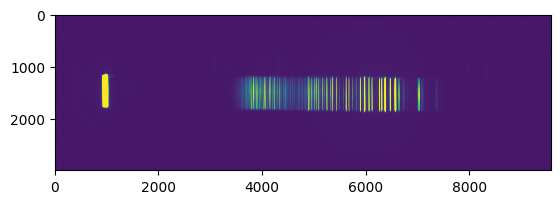

In [31]:
file=fits.open("ne_ar_cal_15s_exp20.fit")
spectrum=file[0].data
spec=spectrum[2000:5000,:]

plt.imshow(spec,vmin=np.percentile(spec, 1), vmax=np.percentile(spec, 99))

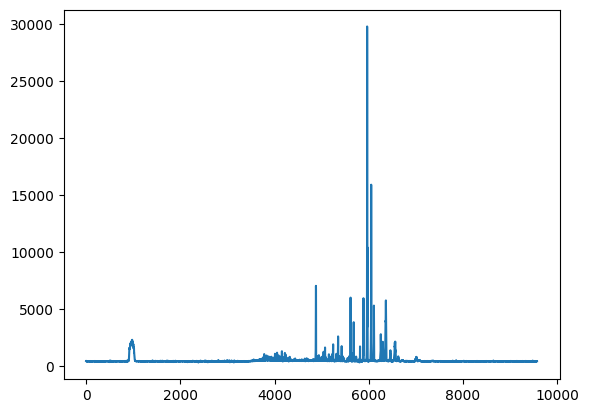

In [29]:
plt.plot(spectrum[3500,:])

### Reading in NIST spectrum for NeAr

In [19]:
near=pd.read_csv('near.txt')

near['obs_wl_air(nm)'] = near['obs_wl_air(nm)'].map(lambda x: x.lstrip('="').rstrip('"'))
near['intens'] = near['intens'].map(lambda x: x.lstrip('="').rstrip('"'))
near['intens'] = near['intens'].map(lambda x: x.rstrip('*'))

near['intens']=near['intens'].astype(str).astype(int)
near['obs_wl_air(nm)']=near['obs_wl_air(nm)'].astype(str).astype(float)

# near_filt=near[near['intens']>500]

### Comparing NIST spectrum for NeAr to the calibration spectrum we took

9576


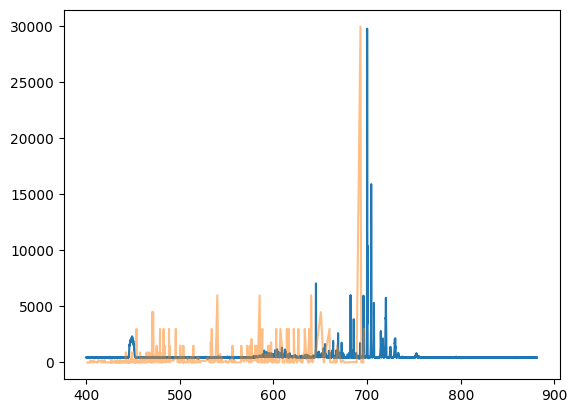

In [20]:
file=fits.open("ne_ar_cal_15s_exp20.fit")

spec=file[0].data
strip=spec[3500,:]
print(len(strip))

xdata=np.linspace(400,881.5,len(strip))

plt.plot(xdata,strip)

plt.plot(near['obs_wl_air(nm)'],near['intens']*0.3,alpha=0.5)

# plt.xlim(5750,6250)

#5965 pix = 700 nm


In [ ]:
# the spectra are slightly crooked. so derive wavelength solution at position of star
# like if your star is at 4000,1500, derive wavelength soln for that position

# taking median from [0:500,:] as 'background' for helium and near
# verify no wavelength dependence for sky background
# then rawspec is ((spectrum-bkgd)[1000:1100, :]).sum(axis=0)
# helium lines are easier to recognize
# linear relationship between wavelength vals and pix vals, on order of ten lines? 
# ^ I think maybe he means the strongest 8-10 lines?

# array of line list in angstroms ie where each line is
# array of pix index vals where each line is (do line fitting to get a precise number)

# then he does a linear fit between wav on y and pix on y
# once you've done the initial linear fit, there should just be an "offset" / phase shift
# that you can add in pix vals to stellar spectra
#%matplotlib widget – ipympl

## Image calibration

$$
\text{Calibrated Image} ;=;
\frac{,(L - B) - \left(\frac{T_L}{T_D}\right)(D - B),}
{\left[(F - B) - \left(\frac{TF}{T{D,f}}\right)(D_f - B)\right]}
$$

Where:

$L$: raw light image

$B$: master bias

$D$: master dark for the light frames

$D_f$: master dark for the flat frames

$F$: master flat

$T_L$: exposure time of the light

$T_D$: exposure time of the dark used for the light

$TF$: exposure time of the flats

$T{D,f}$: exposure time of the darks used for flats

In [ ]:
# my tasks: NeAr cals (15s), delta cas (60s), gamma cas (60s), beta cas (60s), beta and (60s) – incl. wave cals

# bias frames: 3 of them, 0 seconds long, cal_frames-0001 through cal_frames-0003
# darks for light frames (20s): cal_frames_000120s through cal_frames_000520s
# darks for light frames (60s): cal_frames_000160s through cal_frames_000360s
# darks for light frames (300s): cal_frames_0001300s through cal_frames_0003300s
# darks for flats: 20s darks (since flats are 20s long) 
# flat frames: flat_1 through flat_4 (20s)

### Create master frames for calibration

In [41]:
# set variables for exposure times in seconds -- read in from spreadsheet
sci_exp=60
dark_sci_exp=60
flat_exp=20
dark_flat_exp=20

##########################################################################################################################################

# read in bias frames; these are the same for all frames
bias1=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-0001.fit')
bias2=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-0002.fit')
bias3=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-0003.fit')

# create the master bias by stacking and taking median
master_bias=np.median(np.dstack([bias1,bias2,bias3]),-1)

##########################################################################################################################################

# this changes depending on the science exposure time -- pick frame(s) with exposure time most similiar to exposure time of science frames
dark1_light=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-000160s.fit') - master_bias 

# create the master dark for the light frames by stacking and taking median
master_dark_light=np.median(np.dstack([dark1_light]),-1)
master_dark_light_scaled = master_dark_light * (sci_exp/dark_sci_exp) # scale master dark to science exposure time

##########################################################################################################################################

# this changes depending on the science exposure time -- pick frame(s) with exposure time most similiar to exposure time of science frames
dark1_flat=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-000120s.fit') - master_bias
dark2_flat=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-000220s.fit') - master_bias
dark3_flat=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-000320s.fit') - master_bias

# create the master dark for the flat frames by stacking and taking median
master_dark_flat=np.median(np.dstack([dark1_flat,dark2_flat,dark3_flat]),-1)
master_dark_flat_scaled = master_dark_flat * (flat_exp/dark_flat_exp) # scale master dark to science exposure time

##########################################################################################################################################

# read in flat frames; these are the same for all frames
flat1=fits.getdata('/Users/adignan/courses/obs/lab3/data/flat_1.fit')
flat2=fits.getdata('/Users/adignan/courses/obs/lab3/data/flat_2.fit')
flat3=fits.getdata('/Users/adignan/courses/obs/lab3/data/flat_3.fit')
flat4=fits.getdata('/Users/adignan/courses/obs/lab3/data/flat_4.fit')

flats=[flat1,flat2,flat3,flat4]

flats_cal=[]

# create the master flat
for f in flats:
    f_cal= f - master_bias - master_dark_flat_scaled
    flats_cal.append(f_cal)

master_flat=np.median(np.dstack(flats_cal),-1)
master_flat /= np.median(master_flat)

### Apply master frames to science frames

/var/folders/lh/hfr5b6k95hq4fknmrpwk9t280000gp/T/ipykernel_1313/3969294742.py:14: RuntimeWarning: divide by zero encountered in divide
  sci_cal = numerator / denominator
/var/folders/lh/hfr5b6k95hq4fknmrpwk9t280000gp/T/ipykernel_1313/3969294742.py:14: RuntimeWarning: invalid value encountered in divide
  sci_cal = numerator / denominator
/var/folders/lh/hfr5b6k95hq4fknmrpwk9t280000gp/T/ipykernel_1313/3969294742.py:38: RuntimeWarning: invalid value encountered in add
  sci_final += image


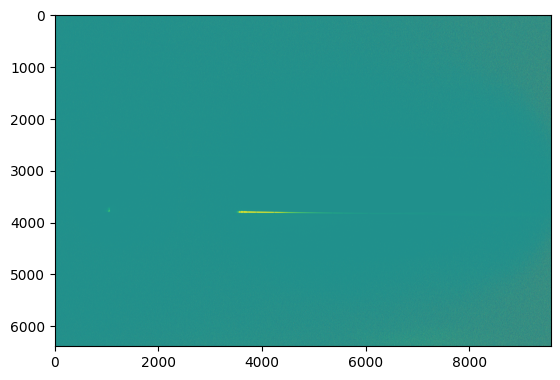

In [43]:
# list of science frames
sci_list=['/Users/adignan/courses/obs/lab3/data/del_cas_60s_exp17.fit',
          '/Users/adignan/courses/obs/lab3/data/del_cas_60s_exp18.fit',
          '/Users/adignan/courses/obs/lab3/data/del_cas_60s_exp19.fit']

# read in science frames and apply master frames to calibrate each science frame
for im in sci_list:
    sci_img=fits.getdata(im)

    numerator = (sci_img - master_bias - master_dark_light_scaled) 

    denominator = master_flat

    sci_cal = numerator / denominator

    # make PrimaryHDU for saving fits file
    hdu = fits.PrimaryHDU(sci_cal)

    # defining output fits file name
    output_filename = im.replace(".fit","_cal.fit")

    # save calibrated frame as fits file
    hdu.writeto(output_filename, overwrite=True)

##########################################################################################################################################

# read in calibrated science frames
sci_cals=['/Users/adignan/courses/obs/lab3/data/del_cas_60s_exp17_cal.fit',
          '/Users/adignan/courses/obs/lab3/data/del_cas_60s_exp18_cal.fit',
          '/Users/adignan/courses/obs/lab3/data/del_cas_60s_exp19_cal.fit']

image_concat = [fits.getdata(image) for image in sci_cals]

sci_final = np.zeros(shape=image_concat[0].shape)

# stack calibrated science frames 
for image in image_concat:
    sci_final += image

    hdu = fits.PrimaryHDU(sci_final)
    
    output_filename = '/Users/adignan/courses/obs/lab3/data/del_cas_cal_stack.fit' # making up a placeholder name for now

    hdu.writeto(output_filename, overwrite=True)

plt.imshow(sci_final,vmin=-556.3350258912469,vmax=550.7467195864338)


### Now writing a function to run the calibration on more than just one file :)

In [45]:
# read in spreadsheet with info

# set variables for exposure times in seconds -- read in from spreadsheet
def calibrate(sci_exp,dark_sci_exp,flat_exp,dark_flat_exp,sci_files,name):

    # read in bias frames; these are the same for all frames
    bias1=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-0001.fit')
    bias2=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-0002.fit')
    bias3=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-0003.fit')

    # create the master bias by stacking and taking median
    master_bias=np.median(np.dstack([bias1,bias2,bias3]),-1)

    ##########################################################################################################################################

    # this changes depending on the science exposure time -- pick frame(s) with exposure time most similiar to exposure time of science frames
    if dark_sci_exp==60:
        
        dark1_light=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-000160s.fit') - master_bias 

        master_dark_light=np.median(np.dstack([dark1_light]),-1)

        # create the master dark for the light frames by stacking and taking median
        master_dark_light_scaled = master_dark_light * (sci_exp/dark_sci_exp) # scale master dark to science exposure time

    if dark_sci_exp==15:

        dark1_light=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-000120s.fit') - master_bias 
        dark2_light=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-000220s.fit') - master_bias 
        dark3_light=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-000320s.fit') - master_bias 

        master_dark_light=np.median(np.dstack([dark1_light,dark2_light,dark3_light]),-1)

        # create the master dark for the light frames by stacking and taking median
        master_dark_light_scaled = master_dark_light * (sci_exp/dark_sci_exp) # scale master dark to science exposure time

    ##########################################################################################################################################

    # this changes depending on the science exposure time -- pick frame(s) with exposure time most similiar to exposure time of science frames
    if dark_flat_exp==60:

        dark1_flat=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-000160s.fit') - master_bias

        # create the master dark for the flat frames by stacking and taking median
        master_dark_flat=np.median(np.dstack([dark1_flat]),-1)
        master_dark_flat_scaled = master_dark_flat * (flat_exp/dark_flat_exp) # scale master dark to science exposure time

    if dark_flat_exp==20:

        dark1_flat=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-000120s.fit') - master_bias
        dark2_flat=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-000220s.fit') - master_bias
        dark3_flat=fits.getdata('/Users/adignan/courses/obs/lab3/data/cal_frames-000320s.fit') - master_bias

        # create the master dark for the flat frames by stacking and taking median
        master_dark_flat=np.median(np.dstack([dark1_flat,dark2_flat,dark3_flat]),-1)
        master_dark_flat_scaled = master_dark_flat * (flat_exp/dark_flat_exp) # scale master dark to science exposure time

    ##########################################################################################################################################

    # read in flat frames; these are the same for all frames
    flat1=fits.getdata('/Users/adignan/courses/obs/lab3/data/flat_1.fit')
    flat2=fits.getdata('/Users/adignan/courses/obs/lab3/data/flat_2.fit')
    flat3=fits.getdata('/Users/adignan/courses/obs/lab3/data/flat_3.fit')
    flat4=fits.getdata('/Users/adignan/courses/obs/lab3/data/flat_4.fit')

    flats=[flat1,flat2,flat3,flat4]

    flats_cal=[]

    # create the master flat
    for f in flats:
        f_cal= f - master_bias - master_dark_flat_scaled
        flats_cal.append(f_cal)

    master_flat=np.median(np.dstack(flats_cal),-1)
    master_flat /= np.median(master_flat)

    sci_cals=[]

    # read in science frames and apply master frames to calibrate each science frame
    for im in sci_files:
        sci_img=fits.getdata(im)

        numerator = (sci_img - master_bias - master_dark_light_scaled) 

        denominator = master_flat

        sci_cal = numerator / denominator

        # make PrimaryHDU for saving fits file
        hdu = fits.PrimaryHDU(sci_cal)

        # defining output fits file name
        output_filename = im.replace(".fit","_cal.fit")
        sci_cals.append(output_filename)

        # save calibrated frame as fits file
        hdu.writeto(output_filename, overwrite=True)

    ##########################################################################################################################################

    # read in calibrated science frames

    image_concat = [fits.getdata(image) for image in sci_cals]

    sci_final = np.zeros(shape=image_concat[0].shape)

    # stack calibrated science frames 
    for image in image_concat:
        sci_final += image

        hdu = fits.PrimaryHDU(sci_final)
        
        output_filename = f'/Users/adignan/courses/obs/lab3/data/{name}_cal_stack.fit' # making up a placeholder name for now

        hdu.writeto(output_filename, overwrite=True)

### Writing a nested dictionary to run the function on

In [56]:
source_list = {
    "del_cas": {
        "source": "delta cas",
        "sci_exp": 60,
        "dark_sci_exp": 60,
        "flat_exp": 20,
        "dark_flat_exp": 60,
        "files": ["/Users/adignan/courses/obs/lab3/data/del_cas_60s_exp17.fit", 
                  "/Users/adignan/courses/obs/lab3/data/del_cas_60s_exp18.fit", 
                  "/Users/adignan/courses/obs/lab3/data/del_cas_60s_exp19.fit"],
    },
    "near_del_cas": {
        "source": "delta cas near",
        "sci_exp": 15,
        "dark_sci_exp": 15,
        "flat_exp": 20,
        "dark_flat_exp": 20,
        "files": ["/Users/adignan/courses/obs/lab3/data/ne_ar_cal_15s_exp20.fit"],
    },
    "gam_cas": {
        "source": "gamma cas",
        "sci_exp": 60,
        "dark_sci_exp": 60,
        "flat_exp": 20,
        "dark_flat_exp": 60,
        "files": ["/Users/adignan/courses/obs/lab3/data/gam_cas_60s_exp13.fit",
                  "/Users/adignan/courses/obs/lab3/data/gam_cas_60s_exp14.fit",
                  "/Users/adignan/courses/obs/lab3/data/gam_cas_60s_exp15.fit"],
    },
    "near_gam_cas": {
        "source": "gamma cas near",
        "sci_exp": 15,
        "dark_sci_exp": 15,
        "flat_exp": 20,
        "dark_flat_exp": 20,
        "files": ["/Users/adignan/courses/obs/lab3/data/ne_ar_cal_15s_exp16.fit"],
    },
    "bet_cas": {
        "source": "beta cas",
        "sci_exp": 60,
        "dark_sci_exp": 60,
        "flat_exp": 20,
        "dark_flat_exp": 60,
        "files": ["/Users/adignan/courses/obs/lab3/data/bet_cas_60s_exp5.fit", 
                  "/Users/adignan/courses/obs/lab3/data/bet_cas_60s_exp6.fit", 
                  "/Users/adignan/courses/obs/lab3/data/bet_cas_60s_exp7.fit",
                  "/Users/adignan/courses/obs/lab3/data/bet_cas_60s_exp8.fit"],
    },
    "near_bet_cas": {
        "source": "beta cas near",
        "sci_exp": 15,
        "dark_sci_exp": 15,
        "flat_exp": 20,
        "dark_flat_exp": 20,
        "files": ["/Users/adignan/courses/obs/lab3/data/ne_ar_cal_15s_exp9.fit"],
    },
    "bet_and": {
        "source": "beta and",
        "sci_exp": 60,
        "dark_sci_exp": 60,
        "flat_exp": 20,
        "dark_flat_exp": 60,
        "files": ["/Users/adignan/courses/obs/lab3/data/beta_and_60s_exp25.fit", 
                  "/Users/adignan/courses/obs/lab3/data/beta_and_60s_exp26.fit", 
                  "/Users/adignan/courses/obs/lab3/data/beta_and_60s_exp28.fit"],
    },
    "near_bet_and": {
        "source": "beta and near",
        "sci_exp": 15,
        "dark_sci_exp": 15,
        "flat_exp": 20,
        "dark_flat_exp": 20,
        "files": ["/Users/adignan/courses/obs/lab3/data/ne_ar_cal_15s_exp29.fit"],
    }
}

### Running the function

In [57]:
# def calibrate(sci_exp,dark_sci_exp,flat_exp,dark_flat_exp,sci_files,name):

for k,d in source_list.items():
    calibrate(d['sci_exp'],d['dark_sci_exp'],d['flat_exp'],d['dark_flat_exp'],d['files'],k)


/var/folders/lh/hfr5b6k95hq4fknmrpwk9t280000gp/T/ipykernel_1313/2478977448.py:88: RuntimeWarning: divide by zero encountered in divide
  sci_cal = numerator / denominator
/var/folders/lh/hfr5b6k95hq4fknmrpwk9t280000gp/T/ipykernel_1313/2478977448.py:88: RuntimeWarning: invalid value encountered in divide
  sci_cal = numerator / denominator
/var/folders/lh/hfr5b6k95hq4fknmrpwk9t280000gp/T/ipykernel_1313/2478977448.py:110: RuntimeWarning: invalid value encountered in add
  sci_final += image


### Running the function just for the He and NeAr lamps for P Cyg

In [98]:
# def calibrate(sci_exp,dark_sci_exp,flat_exp,dark_flat_exp,sci_files,name):

# helium - 3 sec exp
calibrate(3,15,20,20,['/Users/adignan/courses/obs/lab3/data/p_cyg_wave_cal_he.fit'],'he')

# near - 15 sec exp
calibrate(15,15,20,20,['/Users/adignan/courses/obs/lab3/data/p_cyg_wave_cal_near.fit'],'near')

/var/folders/lh/hfr5b6k95hq4fknmrpwk9t280000gp/T/ipykernel_1313/2478977448.py:88: RuntimeWarning: divide by zero encountered in divide
  sci_cal = numerator / denominator
/var/folders/lh/hfr5b6k95hq4fknmrpwk9t280000gp/T/ipykernel_1313/2478977448.py:88: RuntimeWarning: invalid value encountered in divide
  sci_cal = numerator / denominator


In [ ]:
# dispersion in Angstroms/pix: slope from wave cal - linear
# dispersion in Angstroms/mm: slope from wave cal but how many mm in a pix? - linear
# size of resolution element in pix and λ using FWHM: Gaussian?  Δλ
# resolution: λ/Δλ, FWHM = Δλ, central wavelength = λ? diff b/w pix 2 and pix 1 in angstroms?


## Wavelength calibration

### Read in appropriate files

In [3]:
%matplotlib widget

# we only took a spectrum of the helium lamp once, for P Cyg, so read that and the NeAr lamp spectrum in
he=fits.getdata('/Users/adignan/courses/obs/lab3/data/he_cal_stack.fit')[2500:6000, :]
near=fits.getdata('/Users/adignan/courses/obs/lab3/data/near_cal_stack.fit')[2500:6000, :]

# taking slices of blank region of sky for background subtraction
he_slice=he[3300:3700, :]
he_slice_filt=he_slice[np.isfinite(he_slice)]

near_slice=near[3300:3700, :]
near_slice_filt=near_slice[np.isfinite(near_slice)]

# assume no wavelength dependence in sky background
bkgd_he = np.median(he_slice_filt)
bkgd_near = np.median(near_slice_filt)

# perform background subtraction and sum down the rows (giving us a single value per column)
spec_he = ((he - bkgd_he)[1000:1100, :]).sum(axis=0)
spec_near = ((near - bkgd_near)[1000:1100, :]).sum(axis=0)

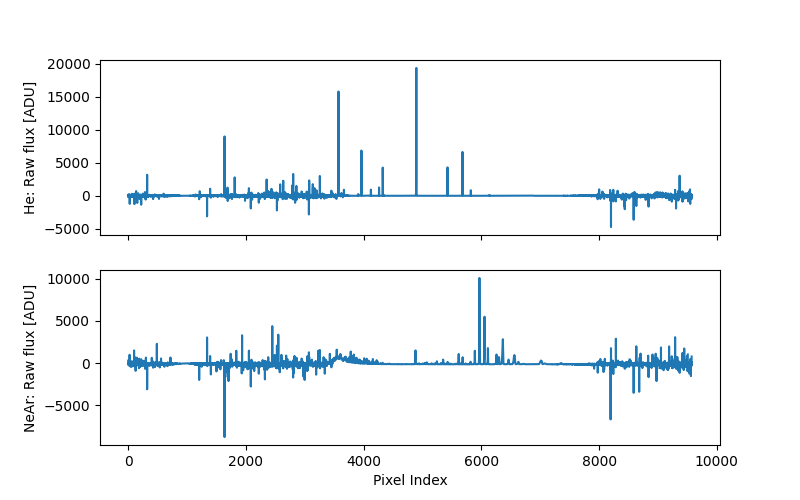

In [11]:
# calculating how many "channels" we have (# of pixels in x direction)
wl_index = np.arange(he.shape[1])

# plotting the two spectra against channels
fig, (ax1, ax2) = plt.subplots(figsize=(8, 5), nrows=2, ncols=1, sharex=True)

ax1.plot(wl_index, spec_he)
# ax1.set_yscale('log')
ax2.plot(wl_index, spec_near)
# ax2.set_yscale('log')

ax2.set_xlabel('Pixel Index')
ax1.set_ylabel('He: Raw flux [ADU]')
ax2.set_ylabel('NeAr: Raw flux [ADU]')

lineList = np.array([3880, 4470, 5010, 5880, 6680, 7060, 7280]) # pick peaks from ideal spectrum (nm to Å)
xList = np.array([3571, 3959, 4320, 4893, 5424, 5676, 5817]) # pick peaks from our spectrum (pix)

### Helium spectrum example from Yifan

![Helium spectrum example](he_spec.jpg "Title")

### Perform a linear fit to get correspondence between pixels and wavelength

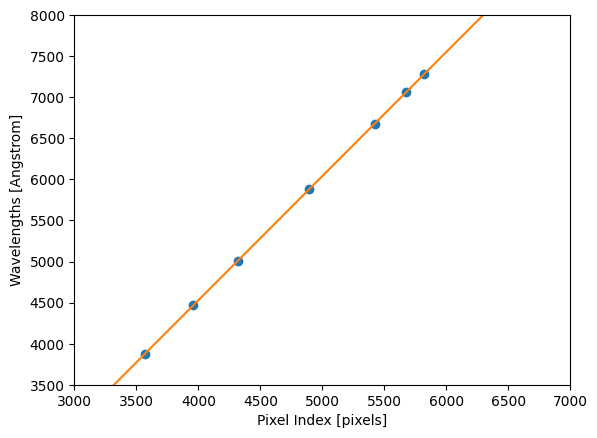

In [ ]:
%matplotlib inline

# Yifan's function for a linear fit :)
def linear_fit(x, y):
    """
    Perform an analytical solution to fit y = mx + b.

    Parameters:
    x (array-like): Independent variable.
    y (array-like): Dependent variable.

    Returns:
    tuple: Slope (m) and intercept (b).
    """
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xx = np.sum(x * x)
    sum_xy = np.sum(x * y)

    m = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x**2) # least squares fitting?
    b = (sum_y - m * sum_x) / n

    return m, b

m_wavecal, b_wavecal = linear_fit(xList, lineList)
wl = m_wavecal * wl_index + b_wavecal # to get λ, input a pixel value; so slope shoudl be in units of λ [Å]/pix

plt.figure()
plt.plot(xList, lineList, 'o')
plt.plot(wl_index, wl)
plt.xlim([3000, 7000])
plt.ylim([3500, 8000])
plt.xlabel('Pixel Index [pixels]')
plt.ylabel('Wavelengths [Angstrom]')

plt.show()